# Vecotrization and Explainability Report

In [1]:
import pandas as pd
import yaml
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
import xgboost
import shap
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def load_params(param_path: str):
    with open(param_path, "r") as f:
        return yaml.safe_load(f)
    
def df_from_json(path: str) -> pd.DataFrame:
    return pd.read_json(f"{path}")

params_yaml = load_params("../params.yaml")["amazon"]
y_name = params_yaml["feature_extraction"]["y_name"]
text_column = params_yaml["feature_extraction"]["text_columns"][0]
categorical_columns = params_yaml["feature_extraction"]["categorical_columns"]
numerical_columns = params_yaml["feature_extraction"]["numerical_columns"]

In [3]:
df_train = df_from_json(
    f"{params_yaml['feature_extraction']['train_pipeline']}/TrainPipelineamazon.json"
)
df_test = df_from_json(
    f"{params_yaml['feature_extraction']['test_pipeline']}/TestPipelineamazon.json"
)

scoring = params_yaml["model_training"]["scoring"]
X_train, y_train = df_train.drop([y_name], axis=1), df_train[y_name]
X_test, y_test = df_test.drop([y_name], axis=1), df_test[y_name]

X_train.drop(params_yaml["model_training"]["feature_engineering_drop"], axis=1, inplace=True)
X_test.drop(params_yaml["model_training"]["feature_engineering_drop"], axis=1, inplace=True)

for col in params_yaml["model_training"]["feature_engineering_drop"]:
    if col in text_column:
        text_column.remove(col)
    elif col in categorical_columns:
        categorical_columns.remove(col)
    elif col in numerical_columns:
        numerical_columns.remove(col)
        
categorical_columns_idx = [X_train.columns.get_loc(col) for col in categorical_columns]
numerical_columns_idx = [X_train.columns.get_loc(col) for col in numerical_columns]
text_column_idx = X_train.columns.get_loc(text_column)

## Define Pipelines using custom vectorizations

In [4]:
preprocessor_BoW = ColumnTransformer(
    transformers=[
        ('categorize', OneHotEncoder(handle_unknown='ignore'), categorical_columns_idx),
        ('standarize', StandardScaler(), numerical_columns_idx),
        ('vectorize', CountVectorizer(max_features=params_yaml["model_training"]["vectorizer_max_features"]), text_column_idx)
    ]
)
preprocessor_tfidf = ColumnTransformer(
    transformers=[
        ('categorize', OneHotEncoder(handle_unknown='ignore'), categorical_columns_idx),
        ('standarize', StandardScaler(), numerical_columns_idx),
        ('vectorize', TfidfVectorizer(max_features=params_yaml["model_training"]["vectorizer_max_features"]), text_column_idx)
    ]
)
pipeline_rf_BoW = Pipeline(steps=[('preprocessor_BoW', preprocessor_BoW),
                              ('pca', TruncatedSVD(n_components=params_yaml["model_training"]["pca_components_number"])),
                              ('rf', RandomForestClassifier(n_estimators=params_yaml["model_training"]["rf_n_estimators"],
                                                      criterion=params_yaml["model_training"]["rf_criterion"],
                                                      max_depth=params_yaml["model_training"]["rf_max_depth"]))])
pipeline_rf_tfidf = Pipeline(steps=[('preprocessor_tfidf', preprocessor_tfidf),
                              ('pca', TruncatedSVD(n_components=params_yaml["model_training"]["pca_components_number"])),
                              ('rf', RandomForestClassifier(n_estimators=params_yaml["model_training"]["rf_n_estimators"],
                                                      criterion=params_yaml["model_training"]["rf_criterion"],
                                                      max_depth=params_yaml["model_training"]["rf_max_depth"]))])

pipeline_rf_BoW.fit(X_train, y_train)
print(f"Vectorization using BoW, f1 weighted: {f1_score(y_test, pipeline_rf_BoW.predict(X_test), average='weighted')}")
pipeline_rf_tfidf.fit(X_train, y_train)
print(f"Vectorization using TfIdf, f1 weighted: {f1_score(y_test, pipeline_rf_tfidf.predict(X_test), average='weighted')}")

Vectorization using BoW, f1 weighted: 0.7395936729956162
Vectorization using TfIdf, f1 weighted: 0.737479955956692


Jak widać nie ma znaczącej różnicy w jakości między typami wektoryzacji TfIdf, a Bag of Words. Można także zauważyć lekką przewagę wskaźnika F1 weighted na korzyść BoW. Może to być spowodowane obecnymi w Pipelinie innymi stage'ami, które niejako zacierają wpływ wektoryzacji na jakość całego modelu.

## SHAP analysis

In [5]:
shap.initjs()
background = shap.sample(X_test[:1000], 10)
explainer = shap.KernelExplainer(pipeline_rf_BoW.predict_proba,background)
shap_values = explainer.shap_values(X_test[:1000])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
shap.plots.force(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[0],
    features=X_test,
    feature_names=X_test.columns
)

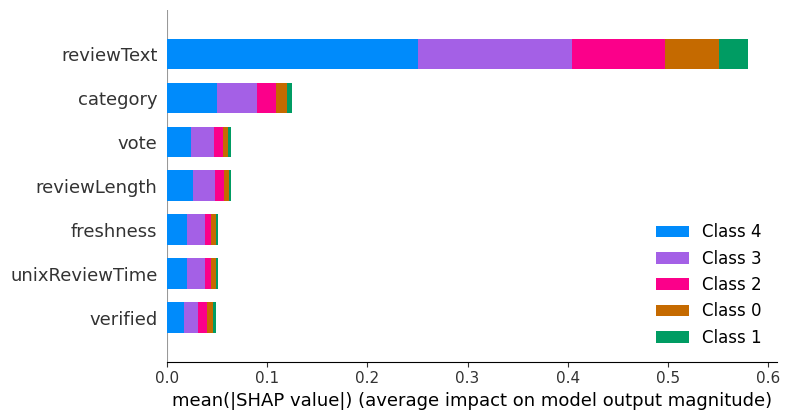

In [7]:
shap.summary_plot(shap_values, features=X_test,
    feature_names=X_test.columns)

## Analiza
Pozytywne oceny mają bardzo duży wpływ na dobrą ocenę sentymentu. Widać jednak także, że znaczący wpływ na ocenę (ogólnie) ma to co piszemy, nie ma takiego wpływu to kiedy to napisaliśmy i czy wypowiedź była długa. Można więc wysnuć wniosek, że największy wpływ na to, czy opinia była pozytywna, czy niegatywna ma treść wpisu. Znaczący wpływ ma także kategoria danego produktu. 
Dużo więcej można się dowiedzieć z analizy wykresem Force. Można na przykład wywnioskować, że kolumna freshness wpływała raczej negatywnie na wynik. Kiedy opinia była świeża wpływała ona na pozytywną opinię.
Warto zauważyć, że opinie pozytywne zwykle są krótkie, podczas gdy długość opinii negatywnych jest dłuższa.